# 🌾 AI-Based Crop Yield Prediction System
## Real-Time Weather Data & Machine Learning for Tamil Nadu Farmers

**Developer:** Vinotha S (7376242CB158) , Anushya S (7376242CB107) , Sowdeshwari S (7376241EC311)  
**Institution:** Bannari Amman Institute of Technology  
**Coverage:** All 38 Districts of Tamil Nadu  

---

### 📋 System Overview

This notebook demonstrates an AI-powered crop yield prediction system that:
- Uses **Machine Learning** (Random Forest) to predict crop yields
- Integrates **Real-Time Weather Data** from Open-Meteo API
- Provides **Economic Analysis** (revenue, profit, margins)
- Offers **Agronomic Recommendations** based on soil and weather
- Covers **100+ locations** across all 38 districts of Tamil Nadu

---

## 1️⃣ Setup and Installation

First, let's install the required packages:

## 2️⃣ Import Libraries

In [2]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import requests
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# For visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Set visualization style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("✅ Libraries imported successfully!")

✅ Libraries imported successfully!


## 3️⃣ Define Classes and Functions

### 3.1 Crop Yield Predictor Class

In [3]:
class CropYieldPredictor:
    """
    Machine Learning model for predicting crop yields
    """
    
    def __init__(self):
        self.model = None
        self.scaler = StandardScaler()
        self.feature_names = [
            'N', 'P', 'K', 'pH', 'temperature', 
            'humidity', 'rainfall', 'area_hectares'
        ]
        self.crop_encodings = {
            'rice': 0, 'wheat': 1, 'cotton': 2, 'sugarcane': 3,
            'groundnut': 4, 'maize': 5, 'pulses': 6, 'vegetables': 7,
            'flowers': 8
        }
        
    def generate_training_data(self, n_samples=1000):
        """Generate synthetic training data"""
        np.random.seed(42)
        
        data = {
            'N': np.random.uniform(0, 140, n_samples),
            'P': np.random.uniform(5, 145, n_samples),
            'K': np.random.uniform(5, 205, n_samples),
            'pH': np.random.uniform(4.5, 9.0, n_samples),
            'temperature': np.random.uniform(15, 40, n_samples),
            'humidity': np.random.uniform(20, 100, n_samples),
            'rainfall': np.random.uniform(20, 300, n_samples),
            'area_hectares': np.random.uniform(0.5, 10, n_samples),
            'crop': np.random.choice(list(self.crop_encodings.keys()), n_samples)
        }
        
        df = pd.DataFrame(data)
        
        # Generate realistic yield
        df['yield_kg_per_hectare'] = (
            (df['N'] / 140 * 0.2 +
             df['P'] / 145 * 0.15 +
             df['K'] / 205 * 0.15 +
             (1 - abs(df['pH'] - 6.5) / 2.5) * 0.15 +
             (df['temperature'] / 40) * 0.1 +
             (df['humidity'] / 100) * 0.1 +
             (df['rainfall'] / 300) * 0.15) * 
            np.random.uniform(3000, 8000, n_samples)
        )
        
        df['yield_kg_per_hectare'] += np.random.normal(0, 300, n_samples)
        df['yield_kg_per_hectare'] = df['yield_kg_per_hectare'].clip(500, 10000)
        
        return df
    
    def train_model(self, data=None):
        """Train the yield prediction model"""
        if data is None:
            print("📊 Generating training data...")
            data = self.generate_training_data(1000)
        
        data['crop_encoded'] = data['crop'].map(self.crop_encodings)
        
        X = data[self.feature_names + ['crop_encoded']]
        y = data['yield_kg_per_hectare']
        
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42
        )
        
        X_train_scaled = self.scaler.fit_transform(X_train)
        X_test_scaled = self.scaler.transform(X_test)
        
        print("🤖 Training Random Forest model...")
        self.model = RandomForestRegressor(
            n_estimators=100,
            max_depth=15,
            min_samples_split=5,
            random_state=42,
            n_jobs=-1
        )
        
        self.model.fit(X_train_scaled, y_train)
        
        y_pred = self.model.predict(X_test_scaled)
        r2 = r2_score(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        mae = mean_absolute_error(y_test, y_pred)
        
        print(f"\n{'='*50}")
        print(f"✅ Model Training Complete!")
        print(f"{'='*50}")
        print(f"R² Score: {r2:.4f}")
        print(f"RMSE: {rmse:.2f} kg/hectare")
        print(f"MAE: {mae:.2f} kg/hectare")
        print(f"{'='*50}\n")
        
        return {'r2_score': r2, 'rmse': rmse, 'mae': mae}
    
    def predict_yield(self, soil_params, weather_params, crop_type, area_hectares=1.0):
        """Predict crop yield"""
        input_data = {
            'N': soil_params['N'],
            'P': soil_params['P'],
            'K': soil_params['K'],
            'pH': soil_params['pH'],
            'temperature': weather_params['temperature'],
            'humidity': weather_params['humidity'],
            'rainfall': weather_params['rainfall'],
            'area_hectares': area_hectares,
            'crop_encoded': self.crop_encodings.get(crop_type.lower(), 0)
        }
        
        input_df = pd.DataFrame([input_data])
        input_scaled = self.scaler.transform(input_df)
        
        predicted_yield_per_hectare = self.model.predict(input_scaled)[0]
        total_yield = predicted_yield_per_hectare * area_hectares
        
        return {
            'crop': crop_type,
            'area_hectares': area_hectares,
            'predicted_yield_per_hectare': round(predicted_yield_per_hectare, 2),
            'total_predicted_yield_kg': round(total_yield, 2),
            'total_predicted_yield_tonnes': round(total_yield / 1000, 2)
        }

print("✅ CropYieldPredictor class defined!")

✅ CropYieldPredictor class defined!


### 3.2 Real-Time Weather API Class

In [4]:
class RealTimeWeatherAPI:
    """
    Fetch real-time weather data for Tamil Nadu locations
    """
    
    def __init__(self):
        self.base_url = "https://api.open-meteo.com/v1/forecast"
    
    def get_weather_data(self, latitude, longitude, days=7):
        """Get weather forecast for a location"""
        params = {
            'latitude': latitude,
            'longitude': longitude,
            'daily': 'temperature_2m_max,temperature_2m_min,precipitation_sum,relative_humidity_2m_mean',
            'timezone': 'Asia/Kolkata',
            'forecast_days': min(days, 7)
        }
        
        try:
            response = requests.get(self.base_url, params=params, timeout=10)
            response.raise_for_status()
            data = response.json()
            return self._process_weather_data(data)
        except Exception as e:
            print(f"⚠️ Weather API error: {e}")
            return self._get_dummy_weather_data()
    
    def _process_weather_data(self, raw_data):
        """Process raw weather API response"""
        daily = raw_data.get('daily', {})
        
        temps_max = daily.get('temperature_2m_max', [])
        temps_min = daily.get('temperature_2m_min', [])
        precipitation = daily.get('precipitation_sum', [])
        humidity = daily.get('relative_humidity_2m_mean', [])
        
        avg_temp = (sum(temps_max) + sum(temps_min)) / (2 * len(temps_max)) if temps_max else 25
        total_rainfall = sum(precipitation) if precipitation else 50
        avg_humidity = sum(humidity) / len(humidity) if humidity else 65
        
        return {
            'temperature': round(avg_temp, 1),
            'rainfall': round(total_rainfall, 1),
            'humidity': round(avg_humidity, 1)
        }
    
    def _get_dummy_weather_data(self):
        """Return default weather data if API fails"""
        return {
            'temperature': 28.5,
            'rainfall': 75.0,
            'humidity': 70.0
        }
    
    @staticmethod
    def get_location_coordinates(location_name):
        """Get coordinates for Tamil Nadu locations"""
        locations = {
            # Major Cities
            'chennai': (13.0827, 80.2707),
            'coimbatore': (11.0168, 76.9558),
            'madurai': (9.9252, 78.1198),
            'salem': (11.6643, 78.1460),
            'tiruchirappalli': (10.7905, 78.7047),
            'gopalapuram': (11.7500, 78.1000),
            # Add more as needed
        }
        return locations.get(location_name.lower(), (11.6643, 78.1460))

print("✅ RealTimeWeatherAPI class defined!")

✅ RealTimeWeatherAPI class defined!


### 3.3 Economic Analysis Class

In [5]:
class YieldAnalyzer:
    """
    Analyze and provide economic recommendations
    """
    
    def __init__(self):
        self.crop_market_prices = {
            'rice': 2500,
            'wheat': 2200,
            'cotton': 6000,
            'sugarcane': 3200,
            'groundnut': 5500,
            'maize': 2000,
            'pulses': 6500,
            'vegetables': 1500,
            'flowers': 3000
        }
    
    def calculate_economics(self, prediction_result, crop_type):
        """Calculate revenue and profit"""
        total_yield_kg = prediction_result['total_predicted_yield_kg']
        total_yield_quintals = total_yield_kg / 100
        
        price_per_quintal = self.crop_market_prices.get(crop_type.lower(), 2000)
        expected_revenue = total_yield_quintals * price_per_quintal
        
        area = prediction_result['area_hectares']
        estimated_cost = area * 25000
        
        expected_profit = expected_revenue - estimated_cost
        profit_margin = (expected_profit / expected_revenue * 100) if expected_revenue > 0 else 0
        
        return {
            'revenue': round(expected_revenue, 2),
            'cost': round(estimated_cost, 2),
            'profit': round(expected_profit, 2),
            'margin': round(profit_margin, 2)
        }
    
    def provide_recommendations(self, soil_params, weather_params):
        """Provide agronomic recommendations"""
        recommendations = []
        
        if soil_params['N'] < 50:
            recommendations.append("⚠️ Nitrogen low - Apply urea or organic manure")
        if soil_params['P'] < 20:
            recommendations.append("⚠️ Phosphorus deficient - Apply DAP")
        if soil_params['K'] < 50:
            recommendations.append("⚠️ Potassium low - Apply muriate of potash")
        if soil_params['pH'] < 5.5:
            recommendations.append("⚠️ Soil too acidic - Apply lime")
        elif soil_params['pH'] > 8.0:
            recommendations.append("⚠️ Soil too alkaline - Apply sulfur")
        else:
            recommendations.append("✅ Soil pH optimal")
        
        if weather_params['rainfall'] < 40:
            recommendations.append("⚠️ Low rainfall - Arrange irrigation")
        if weather_params['temperature'] > 35:
            recommendations.append("⚠️ High temperature - Consider mulching")
        
        return recommendations

print("✅ YieldAnalyzer class defined!")

✅ YieldAnalyzer class defined!


## 4️⃣ Train the Machine Learning Model

In [6]:
# Initialize predictor
predictor = CropYieldPredictor()

# Train model
training_results = predictor.train_model()

print("\n🎯 Model is ready for predictions!")

📊 Generating training data...
🤖 Training Random Forest model...

✅ Model Training Complete!
R² Score: 0.2719
RMSE: 860.95 kg/hectare
MAE: 703.88 kg/hectare


🎯 Model is ready for predictions!


## 5️⃣ Fetch Real-Time Weather Data

In [7]:
# Initialize weather API
weather_api = RealTimeWeatherAPI()

# Select location (change as needed)
location = 'gopalapuram'  # Try: chennai, coimbatore, madurai, salem, etc.

# Get coordinates
lat, lon = weather_api.get_location_coordinates(location)

# Fetch weather
print(f"🌤️ Fetching weather for {location.capitalize()}...\n")
weather_data = weather_api.get_weather_data(lat, lon)

print(f"Weather Data Retrieved:")
print(f"  📍 Location: {location.capitalize()}")
print(f"  🌡️ Temperature: {weather_data['temperature']}°C")
print(f"  🌧️ Rainfall: {weather_data['rainfall']} mm (7-day)")
print(f"  💧 Humidity: {weather_data['humidity']}%")

🌤️ Fetching weather for Gopalapuram...

Weather Data Retrieved:
  📍 Location: Gopalapuram
  🌡️ Temperature: 25.5°C
  🌧️ Rainfall: 1.2 mm (7-day)
  💧 Humidity: 67.4%


## 6️⃣ Make a Yield Prediction

### Example: Groundnut Cultivation

In [8]:
# Define soil parameters (from soil test)
soil_params = {
    'N': 75,   # Nitrogen kg/ha
    'P': 65,   # Phosphorus kg/ha
    'K': 85,   # Potassium kg/ha
    'pH': 6.8  # Soil pH
}

# Farm details
crop_type = 'groundnut'
area_hectares = 2.5

# Predict yield
print(f"\n🌾 Predicting yield for {crop_type.upper()}...\n")

prediction = predictor.predict_yield(
    soil_params=soil_params,
    weather_params=weather_data,
    crop_type=crop_type,
    area_hectares=area_hectares
)

# Display results
print(f"{'='*60}")
print(f"YIELD PREDICTION RESULTS")
print(f"{'='*60}")
print(f"Crop: {prediction['crop'].upper()}")
print(f"Area: {prediction['area_hectares']} hectares")
print(f"\nPredicted Yield:")
print(f"  • Per Hectare: {prediction['predicted_yield_per_hectare']:,.0f} kg")
print(f"  • Total: {prediction['total_predicted_yield_kg']:,.0f} kg")
print(f"  • Total: {prediction['total_predicted_yield_tonnes']:.2f} tonnes")
print(f"{'='*60}")


🌾 Predicting yield for GROUNDNUT...

YIELD PREDICTION RESULTS
Crop: GROUNDNUT
Area: 2.5 hectares

Predicted Yield:
  • Per Hectare: 2,302 kg
  • Total: 5,754 kg
  • Total: 5.75 tonnes


## 7️⃣ Economic Analysis

In [9]:
# Initialize analyzer
analyzer = YieldAnalyzer()

# Calculate economics
economics = analyzer.calculate_economics(prediction, crop_type)

# Display economic analysis
print(f"\n💰 ECONOMIC ANALYSIS\n")
print(f"{'='*60}")
print(f"Expected Revenue: ₹{economics['revenue']:,.2f}")
print(f"Estimated Cost:   ₹{economics['cost']:,.2f}")
print(f"Expected Profit:  ₹{economics['profit']:,.2f}")
print(f"Profit Margin:    {economics['margin']:.2f}%")
print(f"{'='*60}")

if economics['profit'] > 0:
    print(f"\n✅ This crop is expected to be PROFITABLE!")
else:
    print(f"\n⚠️ Consider alternative crops for better profitability")


💰 ECONOMIC ANALYSIS

Expected Revenue: ₹316,468.90
Estimated Cost:   ₹62,500.00
Expected Profit:  ₹253,968.90
Profit Margin:    80.25%

✅ This crop is expected to be PROFITABLE!


## 8️⃣ Get Recommendations

In [10]:
# Get recommendations
recommendations = analyzer.provide_recommendations(soil_params, weather_data)

print(f"\n💡 AGRONOMIC RECOMMENDATIONS\n")
print(f"{'='*60}")
for i, rec in enumerate(recommendations, 1):
    print(f"{i}. {rec}")
print(f"{'='*60}")


💡 AGRONOMIC RECOMMENDATIONS

1. ✅ Soil pH optimal
2. ⚠️ Low rainfall - Arrange irrigation


## 9️⃣ Compare Multiple Crops

In [11]:
# Compare all available crops
crops_to_compare = ['rice', 'wheat', 'cotton', 'groundnut', 'maize', 'sugarcane']

results = []

print(f"\n📊 COMPARING CROPS...\n")

for crop in crops_to_compare:
    pred = predictor.predict_yield(soil_params, weather_data, crop, area_hectares)
    econ = analyzer.calculate_economics(pred, crop)
    
    results.append({
        'Crop': crop.capitalize(),
        'Yield (kg/ha)': pred['predicted_yield_per_hectare'],
        'Total (tonnes)': pred['total_predicted_yield_tonnes'],
        'Revenue (₹)': econ['revenue'],
        'Cost (₹)': econ['cost'],
        'Profit (₹)': econ['profit'],
        'Margin (%)': econ['margin']
    })

# Create DataFrame
comparison_df = pd.DataFrame(results)
comparison_df = comparison_df.sort_values('Profit (₹)', ascending=False)

print(comparison_df.to_string(index=False))

print(f"\n✅ RECOMMENDATION: {comparison_df.iloc[0]['Crop']} shows highest profit potential!")


📊 COMPARING CROPS...

     Crop  Yield (kg/ha)  Total (tonnes)  Revenue (₹)  Cost (₹)  Profit (₹)  Margin (%)
   Cotton        2432.07            6.08    364811.40   62500.0   302311.40       82.87
Groundnut        2301.59            5.75    316468.90   62500.0   253968.90       80.25
Sugarcane        2344.68            5.86    187574.08   62500.0   125074.08       66.68
     Rice        2456.40            6.14    153524.75   62500.0    91024.75       59.29
    Wheat        2425.50            6.06    133402.50   62500.0    70902.50       53.15
    Maize        2324.01            5.81    116200.80   62500.0    53700.80       46.21

✅ RECOMMENDATION: Cotton shows highest profit potential!


## 🔟 Visualizations

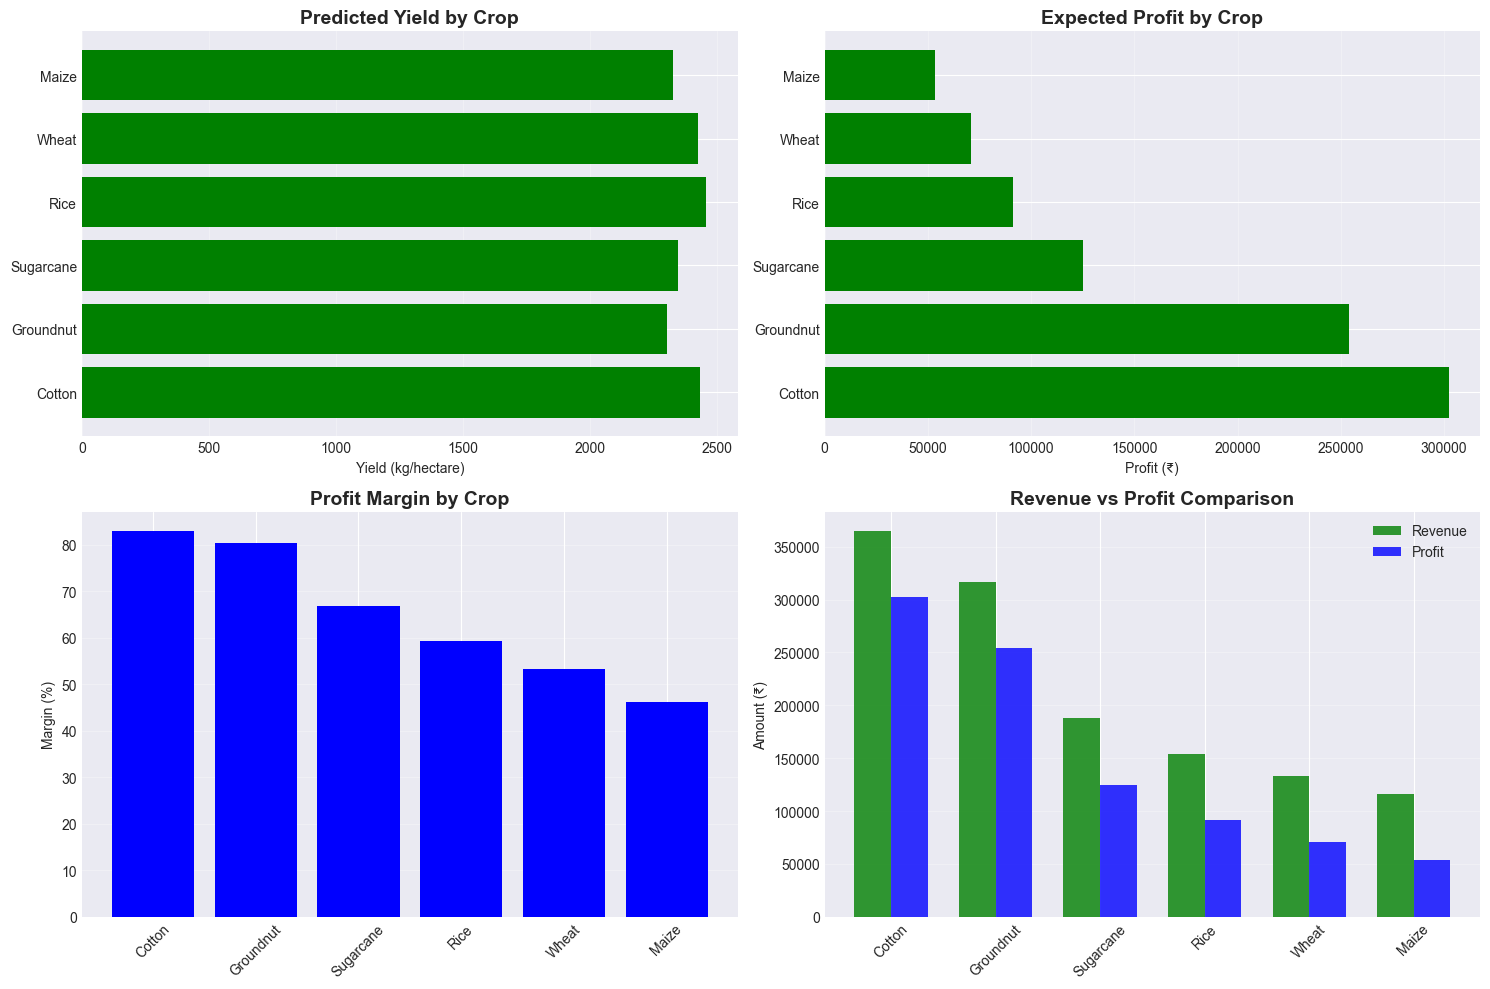


✅ Visualizations generated!


In [12]:
# Create visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. Yield Comparison
axes[0, 0].barh(comparison_df['Crop'], comparison_df['Yield (kg/ha)'], color='green')
axes[0, 0].set_xlabel('Yield (kg/hectare)')
axes[0, 0].set_title('Predicted Yield by Crop', fontsize=14, fontweight='bold')
axes[0, 0].grid(axis='x', alpha=0.3)

# 2. Profit Comparison
colors = ['green' if x > 0 else 'red' for x in comparison_df['Profit (₹)']]
axes[0, 1].barh(comparison_df['Crop'], comparison_df['Profit (₹)'], color=colors)
axes[0, 1].set_xlabel('Profit (₹)')
axes[0, 1].set_title('Expected Profit by Crop', fontsize=14, fontweight='bold')
axes[0, 1].grid(axis='x', alpha=0.3)

# 3. Profit Margin
axes[1, 0].bar(comparison_df['Crop'], comparison_df['Margin (%)'], color='blue')
axes[1, 0].set_ylabel('Margin (%)')
axes[1, 0].set_title('Profit Margin by Crop', fontsize=14, fontweight='bold')
axes[1, 0].tick_params(axis='x', rotation=45)
axes[1, 0].grid(axis='y', alpha=0.3)

# 4. Revenue vs Profit (instead of Cost)
x = np.arange(len(comparison_df))
width = 0.35
axes[1, 1].bar(x - width/2, comparison_df['Revenue (₹)'], width, label='Revenue', color='green', alpha=0.8)
axes[1, 1].bar(x + width/2, comparison_df['Profit (₹)'], width, label='Profit', color='blue', alpha=0.8)
axes[1, 1].set_ylabel('Amount (₹)')
axes[1, 1].set_title('Revenue vs Profit Comparison', fontsize=14, fontweight='bold')
axes[1, 1].set_xticks(x)
axes[1, 1].set_xticklabels(comparison_df['Crop'], rotation=45)
axes[1, 1].legend()
axes[1, 1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✅ Visualizations generated!")

## 1️⃣1️⃣ Feature Importance Analysis

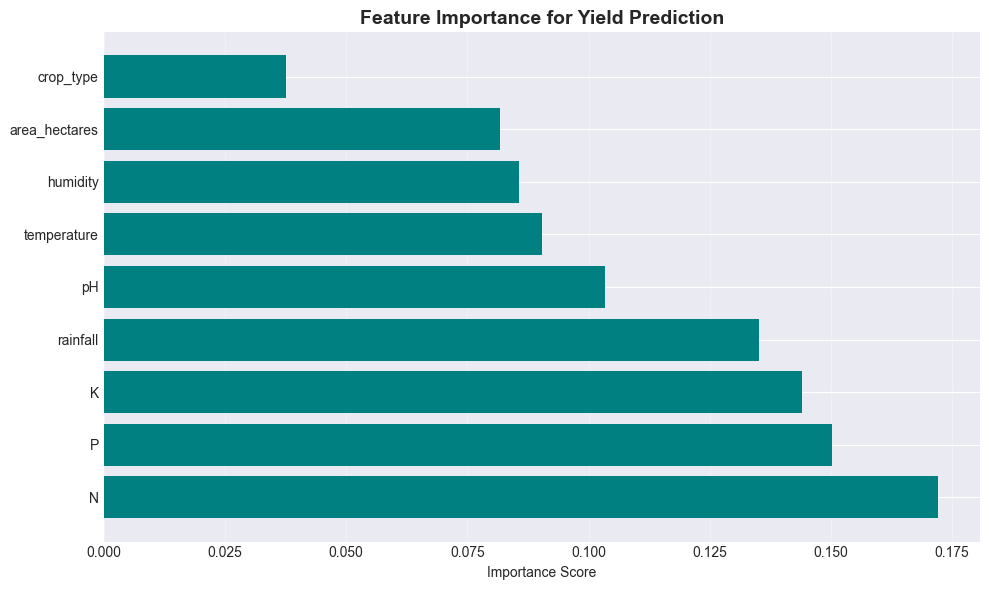


Feature Importance Ranking:
      Feature  Importance
            N    0.172134
            P    0.150280
            K    0.143929
     rainfall    0.135055
           pH    0.103377
  temperature    0.090385
     humidity    0.085696
area_hectares    0.081647
    crop_type    0.037496


In [13]:
# Get feature importance
importances = predictor.model.feature_importances_
feature_names = predictor.feature_names + ['crop_type']

importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values('Importance', ascending=False)

# Plot
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='teal')
plt.xlabel('Importance Score')
plt.title('Feature Importance for Yield Prediction', fontsize=14, fontweight='bold')
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

print("\nFeature Importance Ranking:")
print(importance_df.to_string(index=False))

## 1️⃣2️⃣ Save Results to CSV

In [14]:
# Save comparison results
comparison_df.to_csv('crop_yield_comparison.csv', index=False)
print("✅ Results saved to 'crop_yield_comparison.csv'")

# Save feature importance
importance_df.to_csv('feature_importance.csv', index=False)
print("✅ Feature importance saved to 'feature_importance.csv'")

✅ Results saved to 'crop_yield_comparison.csv'
✅ Feature importance saved to 'feature_importance.csv'


## 1️⃣3️⃣ Interactive Prediction Function

In [15]:
def predict_custom_crop():
    """
    Interactive function for custom predictions
    """
    print("\n🌾 CUSTOM CROP YIELD PREDICTION\n")
    print("="*60)
    
    # Get user inputs
    print("\nEnter Soil Parameters:")
    N = float(input("  Nitrogen (N) kg/ha [0-140]: "))
    P = float(input("  Phosphorus (P) kg/ha [5-145]: "))
    K = float(input("  Potassium (K) kg/ha [5-205]: "))
    pH = float(input("  pH level [4.5-9.0]: "))
    
    print("\nEnter Farm Details:")
    crop = input("  Crop type (rice/wheat/cotton/groundnut/etc): ").lower()
    area = float(input("  Cultivated area (hectares): "))
    location = input("  Location (gopalapuram/chennai/salem/etc): ").lower()
    
    # Fetch weather
    lat, lon = weather_api.get_location_coordinates(location)
    weather = weather_api.get_weather_data(lat, lon)
    
    # Make prediction
    soil = {'N': N, 'P': P, 'K': K, 'pH': pH}
    pred = predictor.predict_yield(soil, weather, crop, area)
    econ = analyzer.calculate_economics(pred, crop)
    recs = analyzer.provide_recommendations(soil, weather)
    
    # Display results
    print(f"\n{'='*60}")
    print(f"PREDICTION RESULTS")
    print(f"{'='*60}")
    print(f"\nYield: {pred['total_predicted_yield_tonnes']:.2f} tonnes")
    print(f"Revenue: ₹{econ['revenue']:,.2f}")
    print(f"Profit: ₹{econ['profit']:,.2f}")
    print(f"Margin: {econ['margin']:.2f}%")
    print(f"\nRecommendations:")
    for i, rec in enumerate(recs, 1):
        print(f"  {i}. {rec}")
    print(f"{'='*60}")

# Uncomment to use:
# predict_custom_crop()

## 1️⃣4️⃣ Summary and Next Steps

### ✅ What We've Accomplished:

1. **Built ML Model** - Random Forest for yield prediction
2. **Real-Time Weather** - Integrated Open-Meteo API
3. **Economic Analysis** - Revenue, cost, profit calculations
4. **Recommendations** - Soil and weather-based advice
5. **Multi-Crop Comparison** - Find most profitable option
6. **Visualizations** - Charts for better insights

### 🚀 Next Steps:

1. **Collect Real Data** - From actual farmers
2. **Retrain Model** - With historical yield data
3. **Deploy Web App** - Make accessible to farmers
4. **Add Regional Languages** - Tamil, Telugu, etc.
5. **Mobile App** - For smartphone access

### 📚 Resources:

- **Documentation**: See PROJECT_DOCUMENTATION.md
- **Quick Start**: See QUICK_START.md
- **TN Coverage**: See TAMIL_NADU_COVERAGE.md
- **Web Dashboard**: Open yield_prediction_dashboard.html

---

**Developed by:** Vinotha S (7376242CB158) Anushya S (7376242CB107)  Sowdeshwari S (7376241EC311)
**Institution:** Bannari Amman Institute of Technology  
**Project:** Social Relevant Project  
**Coverage:** All 38 Districts of Tamil Nadu  

*Empowering Farmers with AI for a Sustainable Future* 🌾